# Machine Learning and Numerical Methods - Project 1

#### Alan Cíntora de la Cruz, Iván Mozún Mateo, Guillermo Ortega Ureta

#### EMJMDP NucPhys

## Introduction

 The aim of this project is to put in practice the acquired knowledge on regression methods and resampling techniques with a more practical problem. With this in mind, we will work with Franke's function, typically used as a test function in interpolation and fitting problems, applying both Ordinary Least Square (OLS) and Ridge regression in order to perform a polynomial fits, considering data scaling and splitting into training and test data. This methods will be then combined with Bootstrap and Cross-validation resampling, in order to analyze the concept of *Bias-Variance Trade-off*. 

 Throughout this whole project we wil be evaluating statistical parameters such as the Mean Square Error and the $R^2$ score function to asess the reliability of our models and make comparisons between them, as well as testing the effect of different parameters such as model complexity on the *Bias-Variance Trade-off*. This will allow us to optimize our models to achieve the best possible accuracy.

 Finally, having tested all this methods and techniques with the simpler Franke's function, we will apply them to some real data, as means to adress how well they work in that case. We are going to work with data from the Boston Housing dataset, that contains information about 13 different features related to housing in Boston.

Firstly, we present the different Python libraries that we are going to be using all through this project:

* `matplotlib`: Includes the tools that we will use for plotting, both in 2D and 3D.

* `numpy`: Very complete library from which we will mainly use its various mathematical functions, support for vector and matrix creation and linear algebra routines.

* `sklearn`: SciKit-learn is a machine learning oriented library from which we use some of its predictive data analysis tools, such as tools for design matrix creation, normalization, train-test splitting, resampling methods and calculation of statistical parameters.

* `pandas`: Data analysis oriented library from which we will mainly use its data manipulation features when dealing with the Boston Housing dataset.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
import pandas as pd

In [2]:
%matplotlib inline

The following block includes the definition of the main class that we will be using all over the next sections of the project, the Regressor class. This class performing a regression of a chosen type, constructing the design matrix and obtaining the estimators and calculating the desired statistical parameters obtained from the fitting.

In [3]:
class Regressor:
    
    """ 
    A class used to build a linear regression model using the OLS or Ridge method.
    
    Attributes
    ----------
    regressor: str
        The method used for the linear regression: "OLS", "Ridge".
    
    X_train, X_test, z_train, z_test: array
        The different arrays for the test and training. X_ refers to the design matrix whereas z_ refers to the
        dataset the model fits.
    
    lambda: float
        The penalizer used in Ridge regression.
    
    Methods
    -------
    MSE_train(), MSE_test(): float
        Returns the mean squared error for the chosen model and the dataset.
    
    r2score_train(), r2score_test(): float
        Returns the value of R2 score function for the chosen model and the dataset.
        
    covariance_beta(sigma): array
        Returns the covariance intervals for the estimators (beta values).
        
    """
    
    def __init__(self, regressor, X_train, X_test, z_train, z_test, lambd = 0):
        
        self.regressor = regressor
        self.X_train = X_train
        self.X_test = X_test
        self.z_train = z_train
        self.z_test = z_test
        self.lambd = lambd
        
        if(regressor == 'OLS'):
            self.beta = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)
        elif(regressor == 'Ridge'):
            self.beta = np.linalg.inv(X_train.T.dot(X_train)+lambd*np.identity(X_train.shape[1])).dot(X_train.T).dot(z_train)
        else:
            raise Exception("Only OLS or Ridge are valid inputs for regressor")
        self.z_pred_train = X_train.dot(self.beta)
        self.z_pred_test = X_test.dot(self.beta)
        
    def MSE_train(self):
        return  mean_squared_error(self.z_train, self.z_pred_train)
    
    def MSE_test(self):
        return  mean_squared_error(self.z_test, self.z_pred_test)
    
    def r2score_train(self):
        return  r2_score(self.z_train, self.z_pred_train)
    
    def r2score_test(self):
        return  r2_score(self.z_test, self.z_pred_test)
    
    def covariance_beta(self,sigma=1.):
        """
            Returns the variances of the estimators of the models.
        
        """
        Conf_Int = []
        
        if(self.regressor == 'OLS'):
            cov_beta = sigma**2*np.linalg.inv(self.X_train.T.dot(self.X_train))
            return cov_beta[np.diag_indices(len(cov_beta))]
                
        elif(self.regressor == 'Ridge'):
            cov_beta = sigma**2*np.linalg.inv(self.X_train.T.dot(self.X_train)+self.lambd*np.identity(self.X_train.shape[1])) 
            return cov_beta[np.diag_indices(len(cov_beta))]

## PART I: Regression analysis of the Franke Function

As mentioned earlier, the function that we will initially work with is the Franke Function. This is a two dimensinal wheighted sum of exponentials with the following analytical expression:

$$f(x,y)=\dfrac{3}{4}\cdot \exp\left[ - \dfrac{(9x-2)^2}{4} - \dfrac{(9y-2)^2}{4} \right] + \dfrac{3}{4}\cdot \exp\left[ - \dfrac{(9x+1)^2}{49} - \dfrac{(9y+1)^2}{10} \right] + \dfrac{1}{2}\cdot \exp\left[ - \dfrac{(9x-7)^2}{4} - \dfrac{(9y-3)^2}{4} \right] - \dfrac{1}{5}\cdot \exp\left[ - (9x-4)^2 -(9y-7)^2\right]$$

defined for: $x,y \in [0,1]$.

In the following block of code we define this function of make a 3D plot of it, where we can see that it presents two gaussian peaks of different heights as well as a small dip.

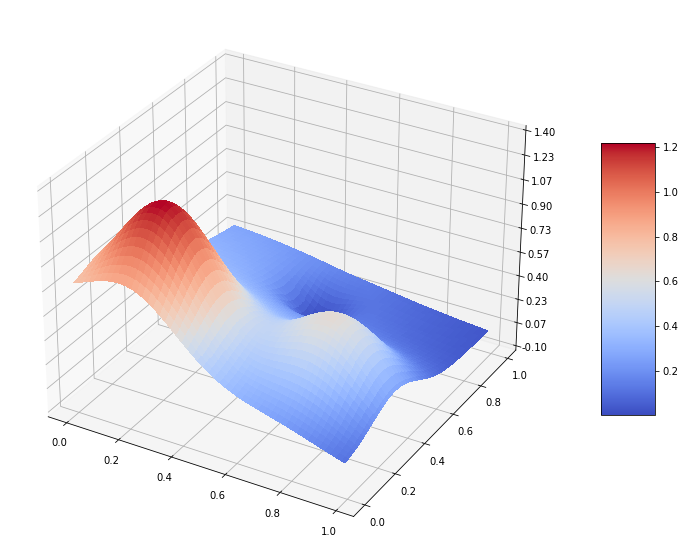

In [4]:
fig = plt.figure(figsize=(18,10))
ax = fig.gca(projection='3d')

# Make data.
x = np.arange(0, 1, 0.01)
y = np.arange(0, 1, 0.01)
x, y = np.meshgrid(x,y)

def FrankeFunction(x,y):
    """
        Returns the value of the Franke function for a given tuple of x, y values.
        
    """
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
linewidth=0, antialiased=False)
# Customize the z axis.

ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [5]:
class FrankeFunctionData:
    """ 
        A class used to get values from the Franke function f(x,y) with noise for a given range of values 
        for x, y.

        Attributes
        ----------
        npoints: int
            The number of points of the x, y arrays. By default is set to 100.

        sigma: float
            Value of the standard deviation associated to the noise.
    
    """
    
    def __init__(self, npoints = 101, sigma = 1.):
        self.x =  np.linspace(0, 1, npoints)
        self.y =  np.linspace(0, 1, npoints)
        self.XX, self.YY = np.meshgrid(self.x,self.y)
        self.x_obs = self.XX.reshape(-1)
        self.y_obs = self.YY.reshape(-1) 
        
        self.X = np.c_[self.x_obs, self.y_obs]
        self.z = FrankeFunction(self.x_obs, self.y_obs) + 0.01*np.random.normal(0,sigma, self.x_obs.shape)
        
    def __call__(self, degree):
        """ 
            Returns the design matrix built for a given linear regression and column vector with the values 
            of the Franke function.

            Parameters
            ----------
            degree: int
                The degree of the polynomial to which the Franke function is fitted.
        
        """
        poly = PolynomialFeatures(degree = degree)
        X_pol = poly.fit_transform(self.X)
        sc = Normalizer().fit(X_pol)
        X_norm = sc.transform(X_pol)
        
        return X_norm, self.z

In [6]:
def Franke_Regression(regressor,degree,lambd = 0.):
    """
        Returns the values for the MSE and R2 score for a given linear regression model.
        
        Arguments
        ---------
        regressor: str 
            The model used for the linear regression: "OLS", "Ridge".
        
        degree: int
            The degree of the polynomial to which the Franke function is fitted.
        
        lambda: float
            The penalizer used in Ridge regression. By default is set as 0.
        
    """
    
    data = FrankeFunctionData()
    X, z = data(degree)
    X_train, X_test, z_train, z_test = train_test_split(X, z, train_size=0.66)
    Reg = Regressor(regressor,X_train,X_test,z_train,z_test)
    
    return Reg.MSE_train(), Reg.MSE_test(), Reg.r2score_train(), Reg.r2score_test(), Reg.covariance_beta()

### a) Ordinary Least Squares (OLS) on the Franke Function

Firstly, we perform a OLS regression of our sampled data, fitting them to an degree 5 polynomial, to asess the behaviour of our method when no resampling is implemented. The OLS regression method consists on solving the mizimization of the Cost Function obtained from the expression of the Mean Square Error. The optimization problem can be written as follows:

$$
{\displaystyle \min_{\boldsymbol{\beta}\in {\mathbb{R}}^{p}}}\frac{1}{n}\left\{\left(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}\right)^T\left(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}\right)\right\}
$$

From this equation we obtain the following expression for the estimators, which are the coefficients of the polynomial that we are using for the fitting:

$$
\boldsymbol{\beta} =\left(\boldsymbol{X}^T\boldsymbol{X}\right)^{-1}\boldsymbol{X}^T\boldsymbol{y}.
$$

When splitting the data into training and test, trials with different weights were performed in order to optimize this parameter. A value of 0.66 was finally chosen, which corresponds to using 2/3 of the data as training, because it is the one that gives the most accurate results, and falls within the typical values most often used for this parameter.

In [7]:
Ols5 = Franke_Regression("OLS",5)

print("MSE (no resampling, train):", Ols5[0])
print("MSE (no resampling, test):", Ols5[1],"\n")

print("R2 score (no resampling, train):", Ols5[2])   
print("R2 score (no resampling, test):", Ols5[3]) 

print(" List of confidence intervals for the estimators (no resampling):", Ols5[4]) 

MSE (no resampling, train): 0.0018863386426422354
MSE (no resampling, test): 0.0018453201537971347 

R2 score (no resampling, train): 0.9773464221147504
R2 score (no resampling, test): 0.9771011810729453
Confidence interval for the estimators (no resampling): [[ 4.17550565e-02 -3.85054478e-01 -3.79731017e-01  1.39449256e+00
   1.65536263e+00  1.36135033e+00 -2.41381575e+00 -3.04851114e+00
  -3.03440046e+00 -2.33680001e+00  1.99626896e+00  2.58861341e+00
   2.75309541e+00  2.57420370e+00  1.91858078e+00 -6.33974466e-01
  -8.29232530e-01 -9.18771974e-01 -9.06956059e-01 -8.28943409e-01
  -6.05195982e-01]
 [-3.85054478e-01  6.85642899e+00  1.59675002e+00 -3.34639033e+01
  -1.68596947e+01 -2.68343512e+00  6.89433970e+01  4.68673149e+01
   1.88098757e+01  1.79420404e+00 -6.39340024e+01 -5.11287955e+01
  -2.81830238e+01 -9.98606333e+00 -7.38272026e-02  2.20099709e+01
   1.95083861e+01  1.26399942e+01  6.47734532e+00  1.96011877e+00
  -2.62356874e-01]
 [-3.79731017e-01  1.59675002e+00  6.83914

### b) Bootstrap resampling and bias-variance trade-off analysis:

In the following block we implement the very general Bootstrap resampling technique and we add it to our regression procedure in order to see its effect on the results. The bootstrap resampling implementation consist in drawing a certain amount of data points from our sample and calculating the estimators that correspond to our regression from those data points. This process is repeated a certain number of times, 20 in our case, and then the final statistical parameters that we consider are the mean of the statistical parameters of each of the runs.

The code that implements resampling with bootstrap technique in the 5th order polynomial of the Franke functions is as follows:

In [8]:
n_bootstrap = 20

MSE_tests_bootstrap = np.zeros(n_bootstrap)
MSE_trains_bootstrap = np.zeros(n_bootstrap)
r2_tests_bootstrap = np.zeros(n_bootstrap)
r2_trains_bootstrap = np.zeros(n_bootstrap)

for i in range(n_bootstrap):
    Ols = Franke_Regression("OLS",5)
    MSE_trains_bootstrap[i] = Ols[0]
    r2_trains_bootstrap[i] = Ols[2]
    MSE_tests_bootstrap[i] = Ols[1]
    r2_tests_bootstrap[i] = Ols[3]

MSE_bootstrap = np.mean(MSE_tests_bootstrap)
r2_bootstrap = np.mean(r2_tests_bootstrap)

In [9]:
print("MSE (no resampling):", Ols5[1])
print("MSE (bootstrap):", MSE_bootstrap,"\n")

print("R2 score (no resampling):", Ols5[3]) 
print("R2 score (bootstrap):", r2_bootstrap)   

MSE (no resampling): 0.0018453201537971347
MSE (bootstrap): 0.0018938760226665605 

R2 score (no resampling): 0.9771011810729453
R2 score (bootstrap): 0.9769150206622459


The results provided from the bootstrap method decrease the mean squared error with respect to the original code. Nevertheless, for the number of times we run the calculation in the bootstrap method, the error does not change significantly, as was proved by ourselves increasing the number of runs does not increase the accuracy of the model, which means that the fitting of the Franke function to a 5th order polynomial without resampling techniques is enough.

#### Optimal value for the degree of the polynomial

OLS regression runs, both with no resampling and with bootstrap resampling, were performed varying the degree of our fitting polynomial from 1 to 12. The following plots show results for the MSE calculated in each of those runs for both the training and the test data, which allows us to analyse the dependance on the complexity of the model, as well as identifying the optimal polynomial degree to fit our dataset with. For both resampling options, we can observe a higher error for lower polynomial degrees, due to those models being too simple of an aproximation to our data. A decrease in the MSE can be seen as the degree increases, up to a point were it starts increasing again, due to the overfitting phenomenon, whose effects are more drastic when using bootstrap resampling. In particular, we see that the preferable polynomial degree is 11 in every case, thus this is the parameter that we will use in subsequent sections.

#### No resampling

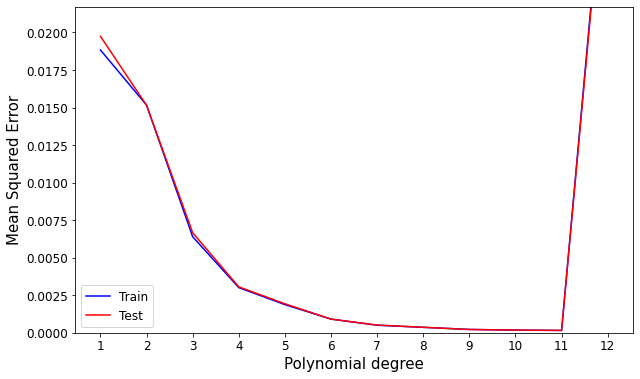

In [10]:
pol = 12
MSE_tests_pol = np.zeros(pol)
MSE_trains_pol = np.zeros(pol)
R2_trains_pol = np.zeros(pol)
R2_tests_pol = np.zeros(pol)
    

for i in range(1,pol+1):
    Ols = Franke_Regression("OLS",i)
    MSE_trains_pol[i-1] = Ols[0]
    MSE_tests_pol[i-1] =Ols[1]
    R2_trains_pol[i-1] = Ols[2]
    R2_tests_pol[i-1] = Ols[3]
    
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(range(1,pol+1),MSE_trains_pol, color = 'blue', label = 'Train')
ax.plot(range(1,pol+1),MSE_tests_pol, color = 'red', label = 'Test')
ax.set_xlabel('Polynomial degree', fontsize=15)
ax.set_ylabel('Mean Squared Error', fontsize=15)

ax.set_ylim(0,1.1*MSE_tests_pol[0])

ax.set_xticks(range(1,pol+1))
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(fontsize=12)
plt.show()

In [11]:
Opt_deg_test = np.where(MSE_trains_pol==np.min(MSE_trains_pol))[0][0]

print(f"MSE (no resampling, test, optimal polynomial: {Opt_deg_test+1}th order):", MSE_tests_pol[Opt_deg_test])
print(f"R2 (no resampling, test, optimal polynomial: {Opt_deg_test+1}th order):", R2_tests_pol[Opt_deg_test])

MSE (no resampling, test, optimal polynomial: 11th order): 0.00015868034056269604
R2 (no resampling, test, optimal polynomial: 11th order): 0.9980842329326203


The previous plot gives us an idea of how an increase in the model complexity (in this case represented by the polynomial degree) affects the prediction error. We see that the optimal value for fitting the Franke function turns to be 11th instead of 5th as we considered previously. Now again, we implement the bootstrap in the previous code.

#### Bootstrap resampling

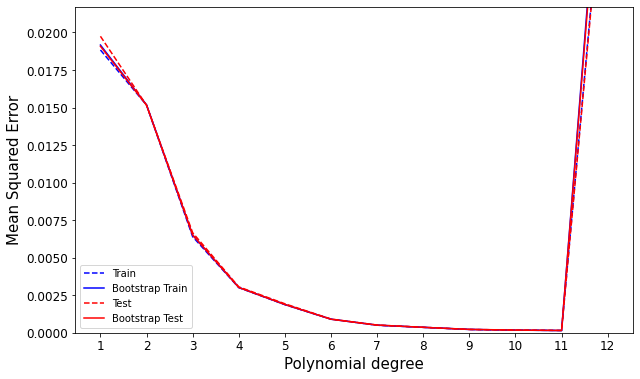

In [14]:
pol = 12

n_bootstrap = 20

MSE_trains_bootstrap = []
r2_trains_bootstrap = []
MSE_tests_bootstrap = []
r2_tests_bootstrap = []


for deg in range(1, pol+1):
    
    MSE_tests = np.zeros(n_bootstrap)
    MSE_trains = np.zeros(n_bootstrap)
    r2_tests = np.zeros(n_bootstrap)
    r2_trains = np.zeros(n_bootstrap)
    
    for i in range(n_bootstrap):
        Ols = Franke_Regression("OLS",deg)
        MSE_trains[i] = Ols[0]
        MSE_tests[i] = Ols[1]
        r2_trains[i] = Ols[2]
        r2_tests[i] = Ols[3]
    
    MSE_trains_bootstrap.append( np.mean(MSE_trains) )
    r2_trains_bootstrap.append( np.mean(r2_trains) )
    MSE_tests_bootstrap.append( np.mean(MSE_tests) )
    r2_tests_bootstrap.append( np.mean(r2_tests) )    
    
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(range(1,pol+1),MSE_trains_pol, "--", color = 'blue', label = 'Train')
ax.plot(range(1,pol+1),MSE_trains_bootstrap, color = 'blue', label = 'Bootstrap Train')
ax.plot(range(1,pol+1),MSE_tests_pol, "--", color = 'red', label = 'Test')
ax.plot(range(1,pol+1),MSE_tests_bootstrap, color = 'red', label = 'Bootstrap Test')

ax.set_xlabel('Polynomial degree', fontsize=15)
ax.set_ylabel('Mean Squared Error', fontsize=15)

ax.set_ylim(0,1.1*MSE_tests_pol[0])

ax.set_xticks(range(1,pol+1))
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend()
plt.show()

In [15]:
Opt_deg_bootstrap = np.where(MSE_tests_bootstrap==np.min(MSE_tests_bootstrap))[0][0]

print(f"MSE (bootstrap, test, optimal polynomial: {Opt_deg_bootstrap+1}th order):", MSE_tests_bootstrap[Opt_deg_bootstrap])
print(f"R2 (bootstrap, test, optimal polynomial: {Opt_deg_bootstrap+1}th order):", r2_tests_bootstrap[Opt_deg_bootstrap])

MSE (bootstrap, test, optimal polynomial: 11th order): 0.00015230584175919632
R2 (bootstrap, test, optimal polynomial: 11th order): 0.9981587049688679


As was expected, when we increase the complexity of the model the implementation of a resampling method increase the results to a greater extent. Again, we find that the best fitting is to a 11th degree polynomial.

#### Bias-variance tradeoff analysis

The cost function used for testing the goodness of our model is the mean squared error:

$$
C(\boldsymbol{X},\boldsymbol{\beta}) =\frac{1}{n}\sum_{i=0}^{n-1}(y_i-\tilde{y}_i)^2=\mathbb{E}\left[(\boldsymbol{y}-\boldsymbol{\tilde{y}})^2\right].
$$

where $\mathbb{E}$ means expected value. Here, the Franke function does not have noisebut we have implement it manually  with a mean and variance equal to 0 and $\sigma^2$, respectively. Therefore, the variance of the data we use for the models has this same variance too, but mean different from zero. If we write explicitly the previous expected value we have
$$
\mathbb{E}\left[(\boldsymbol{y}-\boldsymbol{\tilde{y}})^2\right]=\mathbb{E}\left[(\boldsymbol{f}+\boldsymbol{\epsilon}-\boldsymbol{\tilde{y}})^2\right],
$$

If we add and subtracts $\mathbb{E}\left[\boldsymbol{\tilde{y}}\right]$ to it

$$
\mathbb{E}\left[(\boldsymbol{y}-\boldsymbol{\tilde{y}})^2\right]=\mathbb{E}\left[(\boldsymbol{f}+\boldsymbol{\epsilon}-\boldsymbol{\tilde{y}}+\mathbb{E}\left[\boldsymbol{\tilde{y}}\right]-\mathbb{E}\left[\boldsymbol{\tilde{y}}\right])^2\right],
$$

and we expand it:

$$\begin{aligned}
\mathbb{E}\left[(\boldsymbol{y}+\boldsymbol{\varepsilon}-\boldsymbol{\tilde{y}}+\mathbb{E}[\boldsymbol{\tilde{y}}]-\mathbb{E}[\boldsymbol{\tilde{y}}])^2\right] & =\mathbb{E}\left[(\boldsymbol{y}-\mathbb{E}[\boldsymbol{\tilde{y}}])^2\right]+\mathbb{E}\left[\boldsymbol{\varepsilon}^2\right]+\mathbb{E}\left[(\mathbb{E}[\boldsymbol{\tilde{y}}]-\boldsymbol{\tilde{y}})^2\right]+2 \mathbb{E}[(\boldsymbol{y}-\mathbb{E}[\boldsymbol{\tilde{y}}]) \boldsymbol{\varepsilon}]+2 \mathbb{E}[\boldsymbol{\varepsilon}(\mathbb{E}[\boldsymbol{\tilde{y}}]-\boldsymbol{\tilde{y}})]+2 \mathbb{E}[(\mathbb{E}[\boldsymbol{\tilde{y}}]-\boldsymbol{\tilde{y}})(\boldsymbol{y}-\mathbb{E}[\boldsymbol{\tilde{y}}])] \\
& =(\boldsymbol{y}-\mathbb{E}[\boldsymbol{\tilde{y}}])^2+\mathbb{E}\left[\boldsymbol{\varepsilon}^2\right]+\mathbb{E}\left[(\mathbb{E}[\boldsymbol{\tilde{y}}]-\boldsymbol{\tilde{y}})^2\right]+2(\boldsymbol{y}-\mathbb{E}[\boldsymbol{\tilde{y}}]) \mathbb{E}[\boldsymbol{\varepsilon}]+2 \mathbb{E}[\boldsymbol{\varepsilon}] \mathbb{E}[\mathbb{E}[\boldsymbol{\tilde{y}}]-\boldsymbol{\tilde{y}}]+2 \mathbb{E}[\mathbb{E}[\boldsymbol{\tilde{y}}]-\boldsymbol{\tilde{y}}](\boldsymbol{y}-\mathbb{E}[\boldsymbol{\tilde{y}}]) \\
& =(\boldsymbol{y}-\mathbb{E}[\boldsymbol{\tilde{y}}])^2+\mathbb{E}\left[\boldsymbol{\varepsilon}^2\right]+\mathbb{E}\left[(\mathbb{E}[\boldsymbol{\tilde{y}}]-\boldsymbol{\tilde{y}})^2\right] \\
& =(\boldsymbol{y}-\mathbb{E}[\boldsymbol{\tilde{y}}])^2+\operatorname{Var}[\boldsymbol{\varepsilon}]+\operatorname{Var}[\boldsymbol{\tilde{y}}] \\
& =\operatorname{Bias}[\boldsymbol{\tilde{y}}]^2+\operatorname{Var}[\boldsymbol{\tilde{y}}]+\sigma^2 .
\end{aligned}$$

We find to the formula where the bias and the variance of the model are present. Here, the bias is defined as:
    $$\operatorname{Bias}[\boldsymbol{\tilde{y}}]^2 = (\boldsymbol{y}-\mathbb{E}[\boldsymbol{\tilde{y}}])^2 = \frac{1}{n}\sum_i(\boldsymbol{\tilde{y_i}}-\mathbb{E}\left[\boldsymbol{\tilde{y}}\right])^2$$

Therefore, what can be concluded from the previous result is that error of model depends essentially on 3 parameters:
  - The bias: this term accounts for the deviation of the real data with respect to the model. In this case, we compare the testing data with the mean of the data provided for the model.
  - The variance of the model: this term accounts for the variance of the model itself, i.e. the deviation of the data with respect to the mean.
  - The variance of the noise.

As can be expected, the sum of the bias and the variance should be approximately equal to the MSE. To prove this, we do a analysis of the bias-variance tradeoff by calculating each of these terms. To do so, we implement again the bootstrap method.

In [16]:
from sklearn.utils import resample

pol = 12

n_bootstraps = 100

error = []
bias = []
var = []

data = FrankeFunctionData()

for deg in range(1, pol+1):

    X, z = data(deg)
    X_train, X_test, z_train, z_test = train_test_split(X, z, train_size=0.66)
    columna = np.ones((len(z_test),1))
    
    for i in range(len(z_test)):
        columna[i]=z_test[i]
    
    z_pred = np.empty((z_test.shape[0], n_bootstraps))
    
    for i in range(n_bootstraps):
        X_, z_ = resample(X_train,z_train)
        
        OLS = Regressor("OLS", X_, X_test, z_, z_test)
        z_pred[:, i] = OLS.z_pred_test
    
    bias.append(np.mean( (columna - np.mean(z_pred, axis=1, keepdims=True))**2 ))
    
    var.append(np.mean( np.var(z_pred, axis=1, keepdims=True) ))
    
    error.append(np.mean( np.mean((columna - z_pred)**2, axis=1, keepdims=True) ))

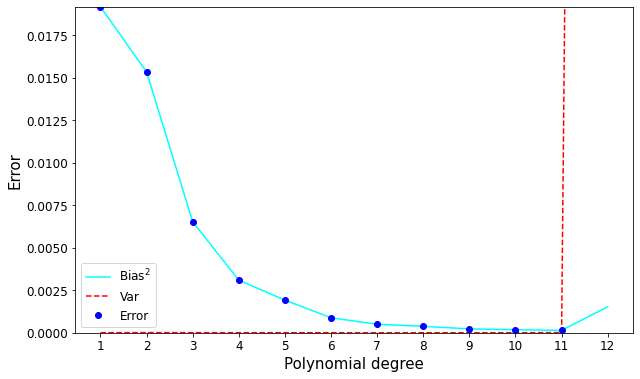

In [18]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(range(1,pol+1),bias, color = 'cyan', label = 'Bias$^2$')
ax.plot(range(1,pol+1),var, "--", color = 'red', label = 'Var')
ax.plot(range(1,pol+1),error, "o", color = 'blue', label = 'Error')

ax.set_xlabel('Polynomial degree', fontsize=15)
ax.set_ylabel('Error', fontsize=15)

ax.set_ylim(0,error[0])

ax.set_xticks(range(1,pol+1))
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(fontsize=12)
plt.show()

In [19]:
for i in range(len(bias)):
    print(f"bias: {bias[i]}, var: {var[i]}, error: {error[i]}")

bias: 0.019168810810182478, var: 8.798731947750852e-06, error: 0.01917760954213023
bias: 0.015340611867596497, var: 1.3552841863986148e-05, error: 0.015354164709460483
bias: 0.00652513980502865, var: 1.0027603015059e-05, error: 0.006535167408043709
bias: 0.003093450230180092, var: 8.245482480947666e-06, error: 0.003101695712661039
bias: 0.0019214739976135106, var: 8.881447770295357e-06, error: 0.0019303554453838064
bias: 0.0008836510551064447, var: 4.961478643535473e-06, error: 0.00088861253374998
bias: 0.0005031258310018623, var: 3.261577135830921e-06, error: 0.0005063874081376931
bias: 0.0003798705240365718, var: 4.659559193143265e-06, error: 0.00038453008322971506
bias: 0.00023151347661508372, var: 2.034212911709873e-06, error: 0.00023354768952679356
bias: 0.00018138400616179193, var: 2.6338885032889515e-06, error: 0.00018401789466508087
bias: 0.00014167535374284184, var: 1.2262689612387708e-05, error: 0.00015393804335522957
bias: 0.001531543046965412, var: 0.2825161979775737, error

As we see, the sum of the bias and the variance returns approximately the total error. Nevertheless, the variance of the model is small and almost negligible. However, in the next figure we show how it varies.

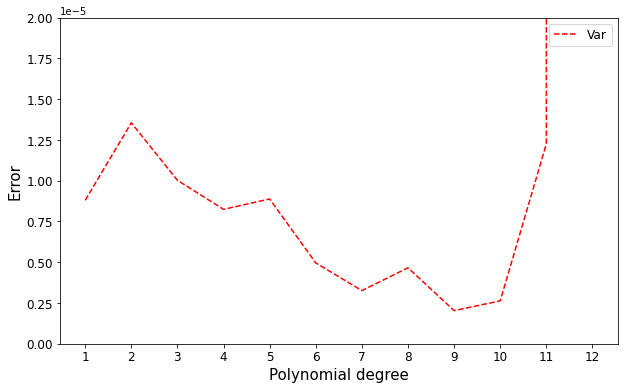

In [20]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(range(1,pol+1),var, "--", color = 'red', label = 'Var')

ax.set_xlabel('Polynomial degree', fontsize=15)
ax.set_ylabel('Error', fontsize=15)

ax.set_ylim(0,0.2e-4)

ax.set_xticks(range(1,pol+1))
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(fontsize=12)
plt.show()

We also see that the variance decreases with the compleximity of the model, finding the minimum for the 9th order polynomial. This differs from our previous study, even though we recall the low values of this parameters. 

### c) Cross-validation resampling techinque

Finally, the more advanced $k$-fold Cross-validation resampling technique is also implemented in the following block. This technique consists in splitting our dataset into a number $k$ of equally sized exhaustive and mutually exclusive subsets. Then, the regression is performed $k$ times, each time using one of the $k$ subsets as test and the rest as training.

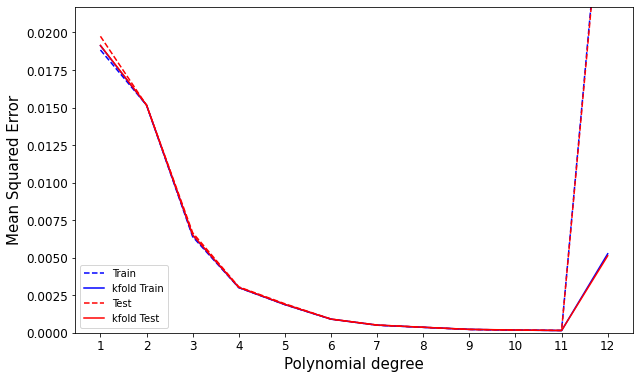

In [21]:
pol = 12

folds = 5
kf = KFold(n_splits=folds,shuffle=True)

MSE_trains_kfold = []
r2_trains_kfold = []
MSE_tests_kfold = []
r2_tests_kfold = []

data = FrankeFunctionData()

for deg in range(1, pol+1):
    
    X_cv, z_cv = data(deg)
    itr = 0

    MSE_tests = np.zeros(folds)
    MSE_trains = np.zeros(folds)
    r2_tests = np.zeros(folds)
    r2_trains = np.zeros(folds)

    for train_i, test_i in kf.split(X_cv):
        
        X_train, X_test, z_train, z_test = X_cv[train_i], X_cv[test_i], z_cv[train_i], z_cv[test_i]
        OLS = Regressor("OLS",X_train,X_test,z_train,z_test)
        
        MSE_tests[itr] = OLS.MSE_test()
        MSE_trains[itr] = OLS.MSE_train()
        r2_tests[itr] = OLS.r2score_test()
        r2_trains[itr] = OLS.r2score_train()
        
        itr +=1

    MSE_trains_kfold.append(np.mean(MSE_trains))
    MSE_tests_kfold.append(np.mean(MSE_tests))
    r2_trains_kfold.append(np.mean(r2_trains))
    r2_tests_kfold.append(np.mean(r2_tests))   
    
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(range(1,pol+1),MSE_trains_pol, "--", color = 'blue', label = 'Train')
ax.plot(range(1,pol+1),MSE_trains_kfold, color = 'blue', label = 'kfold Train')
ax.plot(range(1,pol+1),MSE_tests_pol, "--", color = 'red', label = 'Test')
ax.plot(range(1,pol+1),MSE_tests_kfold, color = 'red', label = 'kfold Test')

ax.set_xlabel('Polynomial degree', fontsize=15)
ax.set_ylabel('Mean Squared Error', fontsize=15)

ax.set_ylim(0,1.1*MSE_tests_pol[0])

ax.set_xticks(range(1,pol+1))
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend()
plt.show()

In [22]:
Opt_deg_kfold = np.where(MSE_tests_kfold==np.min(MSE_tests_kfold))[0][0]

print(f"MSE (kfold, test, optimal polynomial: {Opt_deg_kfold+1}th order):", MSE_tests_kfold[Opt_deg_kfold])
print(f"R2 (kfold, test, optimal polynomial: {Opt_deg_kfold+1}th order):", r2_tests_kfold[Opt_deg_kfold])

MSE (kfold, test, optimal polynomial: 11th order): 0.00015164328970471386
R2 (kfold, test, optimal polynomial: 11th order): 0.9981586525744524


#### OLS: No resampling VS bootstrapping VS kfolding

In [23]:
print(f"MSE (no resampling, test, optimal polynomial: {Opt_deg_test+1}th order):", MSE_tests_pol[Opt_deg_test])
print(f"MSE (bootstrap, test, optimal polynomial: {Opt_deg_bootstrap+1}th order):", MSE_tests_bootstrap[Opt_deg_bootstrap])
print(f"MSE (kfold, test, optimal polynomial: {Opt_deg_kfold+1}th order):", MSE_tests_kfold[Opt_deg_kfold],"\n")

print(f"R2 (no resampling, test, optimal polynomial: {Opt_deg_test+1}th order):", R2_tests_pol[Opt_deg_test])
print(f"R2 (bootstrap, test, optimal polynomial: {Opt_deg_bootstrap+1}th order):", r2_tests_bootstrap[Opt_deg_bootstrap])
print(f"R2 (kfold, test, optimal polynomial: {Opt_deg_kfold+1}th order):", r2_tests_kfold[Opt_deg_kfold])

MSE (no resampling, test, optimal polynomial: 11th order): 0.00015868034056269604
MSE (bootstrap, test, optimal polynomial: 11th order): 0.00015230584175919632
MSE (kfold, test, optimal polynomial: 11th order): 0.00015164328970471386 

R2 (no resampling, test, optimal polynomial: 11th order): 0.9980842329326203
R2 (bootstrap, test, optimal polynomial: 11th order): 0.9981587049688679
R2 (kfold, test, optimal polynomial: 11th order): 0.9981586525744524


The results provided for the two resampling techniques improve the results as we can see. For this model, the cross-validation seems to work better than the bootstrap method. As we will see later, for the Ridge regression this is not the case. 

Therefore, we conclude that the fitting of the Franke function is the provided by a 11th polynomial and the model can give better results when resampling techniques are considered.

### d) Ridge regression on the Franke function

We now implement the next step in advancement from OLS regression: the Ridge regression method. This method consists on the addition of a regularization parameter ($\lambda$) to our optimization problem, thus obtaining a the following new minimization equation:

$$
{\displaystyle \min_{\boldsymbol{\beta}\in
{\mathbb{R}}^{p}}}\frac{1}{n}\vert\vert \boldsymbol{y}-\boldsymbol{X}\boldsymbol{\beta}\vert\vert_2^2+\lambda\vert\vert \boldsymbol{\beta}\vert\vert_1
$$

Solving this equation we can also obtain a new equation for the estimators, which is as follows:

$$
\boldsymbol{\beta}^{\mathrm{Ridge}} = \left(\boldsymbol{X}^T\boldsymbol{X}+\lambda\boldsymbol{I}\right)^{-1}\boldsymbol{X}^T\boldsymbol{y},
$$

We first define a set of different $\lambda$, which we will then use study the dependance of the MSE of our regression on this parameter. We will do this for the case of Ridge regression without resampling, with bootstraping resambling and with cross-validation resampling, as we did for the case of OLS.

In [25]:
lambd = np.logspace(-10, 10, 50)

#### No resampling

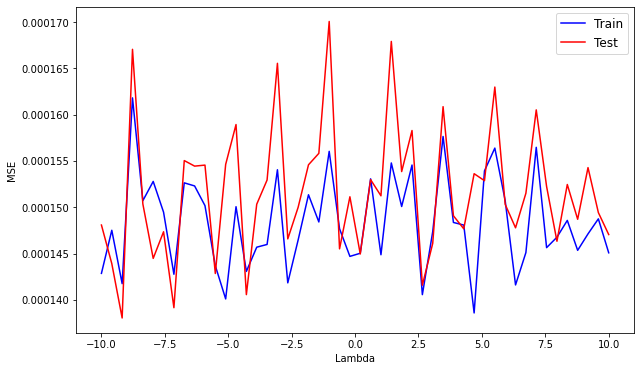

In [26]:
MSE_trains_lambda = []
r2_trains_lambda = []
MSE_tests_lambda = []
r2_tests_lambda = []

for l in lambd:
    
    Ridge_L = Franke_Regression("Ridge",11,l)
    MSE_trains_lambda.append( Ridge_L[0] )
    MSE_tests_lambda.append( Ridge_L[1] )
    r2_trains_lambda.append( Ridge_L[2] )
    r2_tests_lambda.append( Ridge_L[3] )  
    
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.log10(lambd), MSE_trains_lambda, color = 'blue', label = 'Train')
ax.plot(np.log10(lambd), MSE_tests_lambda, color = 'red', label = 'Test')
ax.set_xlabel('Lambda')
ax.set_ylabel('MSE')
ax.legend(fontsize=12)
plt.show()

In [27]:
Opt_lambda_test = np.where(MSE_tests_lambda==np.min(MSE_tests_lambda))[0][0]

print(f"MSE (no resampling, test, optimal log10lambda: {np.log10(lambd[Opt_lambda_test])}):", MSE_tests_lambda[Opt_deg_test])
print(f"R2 (no resampling, test, optimal log10lambda: {np.log10(lambd[Opt_lambda_test])}):", r2_tests_lambda[Opt_deg_test])

MSE (no resampling, test, optimal log10lambda: -9.183673469387756): 0.00015454887068982513
R2 (no resampling, test, optimal log10lambda: -9.183673469387756): 0.9980523974787965


Even though we find a strange behaviour when studying the MSE as a function of lambda parameter, the results with respect to the OLS method are better when no resampling techniques are considered. Thus, we say that the implementation of a this parameter is a good idea

#### Bootstrap resampling technique

In [28]:
n_bootstraps=20

Ridge_MSE_bootstrap_test = np.zeros((n_bootstraps,len(lambd)))
Ridge_MSE_bootstrap_train  = np.zeros((n_bootstraps,len(lambd)))
Ridge_r2_bootstrap_test  = np.zeros((n_bootstraps,len(lambd)))
Ridge_r2_bootstrap_train = np.zeros((n_bootstraps,len(lambd)))

for i, l in enumerate(lambd):
    for j in range(n_bootstraps):
        Ridge = Franke_Regression("Ridge",11,l)
        Ridge_MSE_bootstrap_train[j,i] = Ridge[0]
        Ridge_MSE_bootstrap_test[j,i] = Ridge[1]
        Ridge_r2_bootstrap_train[j,i] = Ridge[2]
        Ridge_r2_bootstrap_test[j,i] = Ridge[3]
        
Lambdas_MSE_bootstrap_test = np.mean(Ridge_MSE_bootstrap_test, axis=0)
Lambdas_MSE_bootstrap_train = np.mean(Ridge_MSE_bootstrap_train, axis=0)
Lambdas_r2_bootstrap_test = np.mean(Ridge_r2_bootstrap_test, axis=0)
Lambdas_r2_bootstrap_train = np.mean(Ridge_r2_bootstrap_train, axis=0)

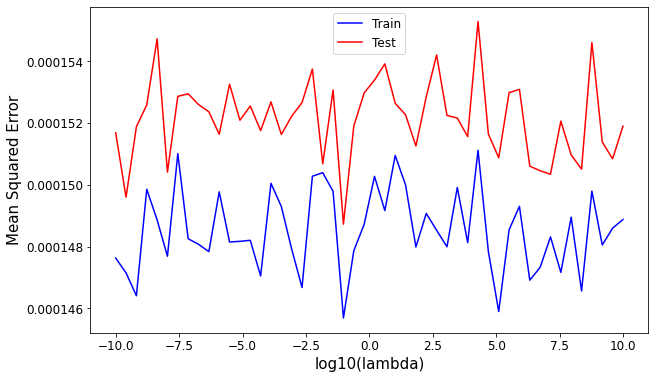

In [29]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(np.log10(lambd), Lambdas_MSE_bootstrap_train, color = 'blue', label = 'Train')
ax.plot(np.log10(lambd), Lambdas_MSE_bootstrap_test, color = 'red', label = 'Test')

ax.set_xlabel('log10(lambda)', fontsize=15)
ax.set_ylabel('Mean Squared Error', fontsize=15)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(fontsize=12)
plt.show()

In [30]:
Opt_bootstrap_test = np.where(Lambdas_MSE_bootstrap_test==np.min(Lambdas_MSE_bootstrap_test))[0][0]

print(f"MSE (bootstrapping, test, optimal log10lambda: {np.log10(lambd[Opt_bootstrap_test])}):", Lambdas_MSE_bootstrap_test[Opt_bootstrap_test])
print(f"R2 (bootstrapping, test, optimal log10lambda: {np.log10(lambd[Opt_bootstrap_test])}):", Lambdas_r2_bootstrap_test[Opt_bootstrap_test])

MSE (bootstrapping, test, optimal log10lambda: -1.020408163265305): 0.00014872403144894366
R2 (bootstrapping, test, optimal log10lambda: -1.020408163265305): 0.9982075833349292


The implementation of bootstrap increase the result when studying the MSE at the train of the model although the error for the test data is not close to the error of the train data, as happened before. Note that the absolut value for the lambda parameter has decreased, thus, when doing resampling the penalization of the beta estimators is reduced.

#### Cross-validation resampling technique

In [31]:
folds = 5
kf = KFold(n_splits=folds,shuffle=True)

Ridge_MSE_kfold_test = np.zeros((folds,len(lambd)))
Ridge_r2_kfold_test = np.zeros((folds,len(lambd)))
Ridge_MSE_kfold_train = np.zeros((folds,len(lambd)))
Ridge_r2_kfold_train = np.zeros((folds,len(lambd)))

data = FrankeFunctionData()
X_cv, z_cv = data(11)
itr = 0

for train_i, test_i in kf.split(X_cv):
    X_train, X_test, z_train, z_test = X_cv[train_i], X_cv[test_i], z_cv[train_i], z_cv[test_i]
    for i, l in enumerate(lambd):
        Ridge = Regressor("Ridge",X_train,X_test,z_train,z_test,l)
        Ridge_MSE_kfold_train[itr,i] = Ridge.MSE_train()
        Ridge_MSE_kfold_test[itr,i] = Ridge.MSE_test()
        Ridge_r2_kfold_train[itr,i] = Ridge.r2score_train()
        Ridge_r2_kfold_test[itr,i] = Ridge.r2score_test()
    itr +=1

Lambdas_MSE_kfold_test = np.mean(Ridge_MSE_kfold_test, axis=0)
Lambdas_MSE_kfold_train = np.mean(Ridge_MSE_kfold_train, axis=0)
Lambdas_r2_kfold_test = np.mean(Ridge_r2_kfold_test, axis=0)
Lambdas_r2_kfold_train = np.mean(Ridge_r2_kfold_train, axis=0)

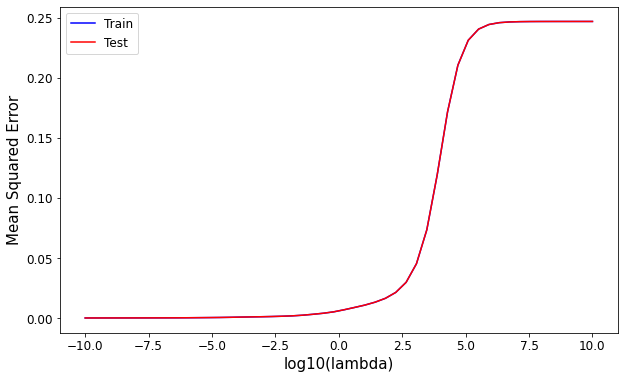

In [32]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(np.log10(lambd), Lambdas_MSE_kfold_train, color = 'blue', label = 'Train')
ax.plot(np.log10(lambd), Lambdas_MSE_kfold_test, color = 'red', label = 'Test')

ax.set_xlabel('log10(lambda)', fontsize=15)
ax.set_ylabel('Mean Squared Error', fontsize=15)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(fontsize=12)
plt.show()

In [33]:
Opt_kfold_test = np.where(Lambdas_MSE_kfold_test==np.min(Lambdas_MSE_kfold_test))[0][0]

print(f"MSE (kfold, test, optimal log10lambda: {np.log10(lambd[Opt_kfold_test])}):", Lambdas_MSE_kfold_test[Opt_kfold_test])
print(f"R2 (kfold, test, optimal log10lambda: {np.log10(lambd[Opt_kfold_test])}):", Lambdas_r2_kfold_test[Opt_kfold_test])

MSE (kfold, test, optimal log10lambda: -10.0): 0.00016705339901962072
R2 (kfold, test, optimal log10lambda: -10.0): 0.9979723889160667


As was said before, the cross-folding method fails when the Ridge regression is used. The value for the beta parameter here is -10, which is the limit we set for their possible values and even, the value for the MSE is greater. We can infer that this resampling technique needs high negative values of lambda parameter to decrease the error, but they won't improve it more than the bootstrap method.

## Conclusion

Throughout this jupyter notebook we have done an study of the Franke function and two of the most common used fitting models: OLS and Ridge regression. We have discussed how this two model work and the results they provided, as well as their complexity, in order to provide the best results. We have also included resampling techniques such as bootstrap and cross-folding methods, that show better results. 

What we have find out is that, the OLS is the simplest model to implement but Ridge is a better model. Both models adjust the Franke function to a 11th degree polynomial since the MSE gives its minimum value at this order. Reagarding the resampling techniques, the cross-validation method works better with OLS and the bootstrapping with Ridge.

We conclude that the best model is: 
- Ridge regression.
- Polynomial of 11th order
- Bootstrap resampling technique